In [34]:
pip install pyqsp

Note: you may need to restart the kernel to use updated packages.


In [35]:
## Generate a code that given the angles that generates a phase for you 
# and manipulate those angles a little bit


In [36]:
pip install cvxpy 

Note: you may need to restart the kernel to use updated packages.


In [37]:
import numpy as np
import scipy

# the size of the unitary which block encodes A
REG_SIZE = 3


def get_random_unitary(num_qubits, seed=4):
    np.random.seed(seed)
    X = np.random.rand(2**num_qubits, 2**num_qubits)
    U, s, V = np.linalg.svd(X)
    return U @ V.T


U_a = get_random_unitary(REG_SIZE)

A_dim = int(U_a.shape[0] / 2)
A = U_a[:A_dim, :A_dim]
print(A)

[[-0.05338002 -0.36103662 -0.54016489 -0.39026125]
 [-0.33304121  0.10648228  0.37346704 -0.33977916]
 [ 0.4167817  -0.75180519  0.17593867  0.20944773]
 [ 0.26891079 -0.05333795 -0.32668787 -0.33602829]]


Max error value: 0.0047009982852195265


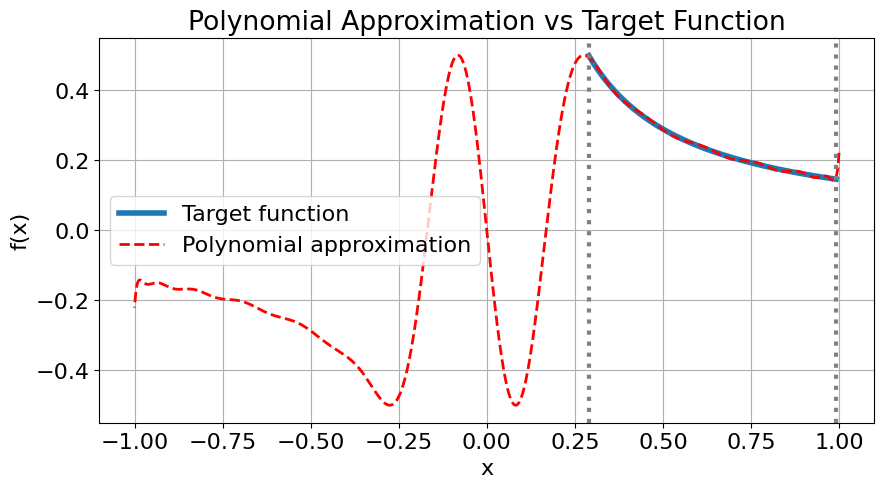

In [38]:
import cvxpy as cp
import matplotlib.pyplot as plt


def optimize_inversion_polynomial(w_min, w_max, degree, M=1000, plot=True):
    # Discretize [-1, 1] using M grid points (interpolants)
    xj_full = np.cos(np.pi * np.arange(M) / (M - 1))  # Chebyshev nodes on [-1, 1]

    # Select grid points for the objective in [w_min, w_max]
    xj_obj = xj_full[(xj_full >= w_min) & (xj_full <= w_max)]

    # Define the Chebyshev polynomials of odd degrees
    k_max = (degree - 1) // 2
    T_matrix_full = np.array(
        [
            [np.cos((2 * k + 1) * np.arccos(x)) for k in range(k_max + 1)]
            for x in xj_full
        ]
    )
    T_matrix_obj = np.array(
        [[np.cos((2 * k + 1) * np.arccos(x)) for k in range(k_max + 1)] for x in xj_obj]
    )

    # Define optimization variables
    c = cp.Variable(k_max + 1)  # Coefficients for Chebyshev polynomials
    F_values_full = T_matrix_full @ c  # Values for constraints
    F_values_obj = T_matrix_obj @ c  # Values for the objective function

    # Relaxed constraint
    scale = 0.5

    def target_function(x):
        return scale * (w_min) / x

    # Define the optimization problem
    objective = cp.Minimize(cp.max(cp.abs(F_values_obj - target_function(xj_obj))))
    constraints = [cp.abs(F_values_full) <= scale]
    prob = cp.Problem(objective, constraints)

    # Solve the optimization problem
    prob.solve()
    print(f"Max error value: {prob.value}")

    # Return coefficients, optimal value, and grid points
    pcoefs = np.zeros(len(c.value) * 2)
    pcoefs[1::2] = c.value

    if plot:
        y_target = target_function(xj_obj)
        y_approx = np.polynomial.Chebyshev(pcoefs)(xj_full)

        # Plot
        plt.figure(figsize=(10, 5))
        plt.plot(xj_obj, y_target, label="Target function", linewidth=4)
        plt.plot(
            xj_full,
            y_approx,
            "--",
            label="Polynomial approximation",
            linewidth=2,
            c="r",
        )
        plt.title("Polynomial Approximation vs Target Function")
        plt.xlabel("x")
        plt.ylabel("f(x)")
        # Draw vertical lines
        plt.axvline(w_min, color="gray", linestyle=":", linewidth=3)
        plt.axvline(w_max, color="gray", linestyle=":", linewidth=3)

        plt.legend()
        plt.grid(True)
        plt.show()

    return pcoefs, scale


svd = np.linalg.svd(A)[1]
pcoefs, scale = optimize_inversion_polynomial(min(svd), max(svd), degree=30)

In [39]:
print(pcoefs)

[ 0.          0.25054832  0.         -0.14629239  0.          0.08051086
  0.          0.00135102  0.         -0.03904751  0.          0.08628945
  0.         -0.09197067  0.          0.10660837  0.         -0.08916949
  0.          0.08359965  0.         -0.057867    0.          0.04664974
  0.         -0.02450966  0.          0.01879831  0.         -0.00429364]


In [40]:
def adjust_phases(ang_seq):
    # change the R(x) to W(x), as the phases are in the W(x) conventions
    phases = np.array(ang_seq)
    phases[1:-1] = phases[1:-1] - np.pi / 2
    phases[0] = phases[0] - np.pi / 4
    phases[-1] = phases[-1] + (2 * (len(phases) - 1) - 1) * np.pi / 4
    
    # verify conventions. minus is due to exp(-i*phi*z) in qsvt in comparison to qsp
    phases = -2 * phases
    return phases


In [41]:
import numpy as np

# Your coefficients (example)
original_coefs = np.array([
    0.0, 0.25054832, 0.0, -0.14629239, 0.0, 0.08051086,
    0.0, 0.00135102, 0.0, -0.03904751, 0.0, 0.08628945,
    0.0, -0.09197067, 0.0, 0.10660837, 0.0, -0.08916949,
    0.0, 0.08359965, 0.0, -0.057867, 0.0, 0.04664974,
    0.0, -0.02450966, 0.0, 0.01879831, 0.0, -0.00429364
])

# Modify selected coefficients slightly (e.g. round the 3rd and 7th odd coefficients)
modified_coefs = original_coefs.copy()

# Example tweak: drop least two significant digits from a few nonzero values
idxs_to_tweak = [1, 3, 5, 15, 29]  # Only odd indices
for idx in idxs_to_tweak:
    modified_coefs[idx] = np.round(modified_coefs[idx], 2)  # Round to 2 decimal places


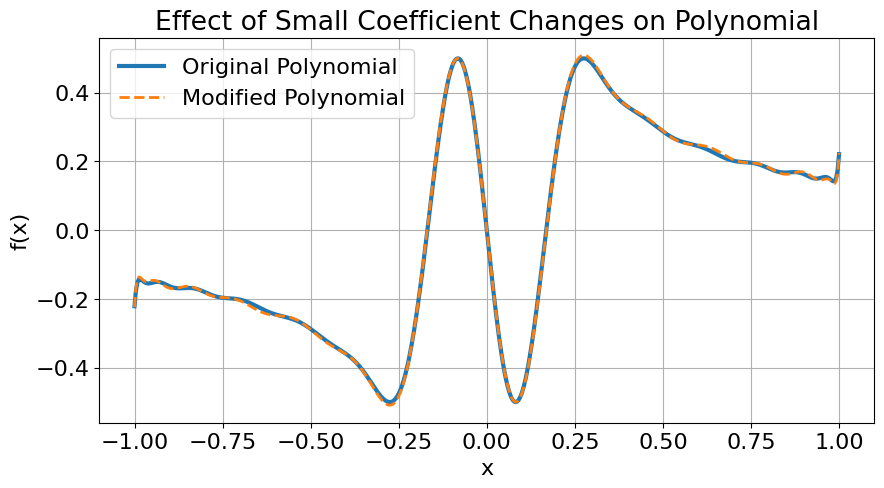

In [42]:
from numpy.polynomial import Chebyshev
import matplotlib.pyplot as plt

x = np.linspace(-1, 1, 500)
P_orig = Chebyshev(original_coefs)(x)
P_mod  = Chebyshev(modified_coefs)(x)

plt.figure(figsize=(10, 5))
plt.plot(x, P_orig, label='Original Polynomial', linewidth=3)
plt.plot(x, P_mod, '--', label='Modified Polynomial', linewidth=2)
plt.title("Effect of Small Coefficient Changes on Polynomial")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.grid(True)
plt.show()


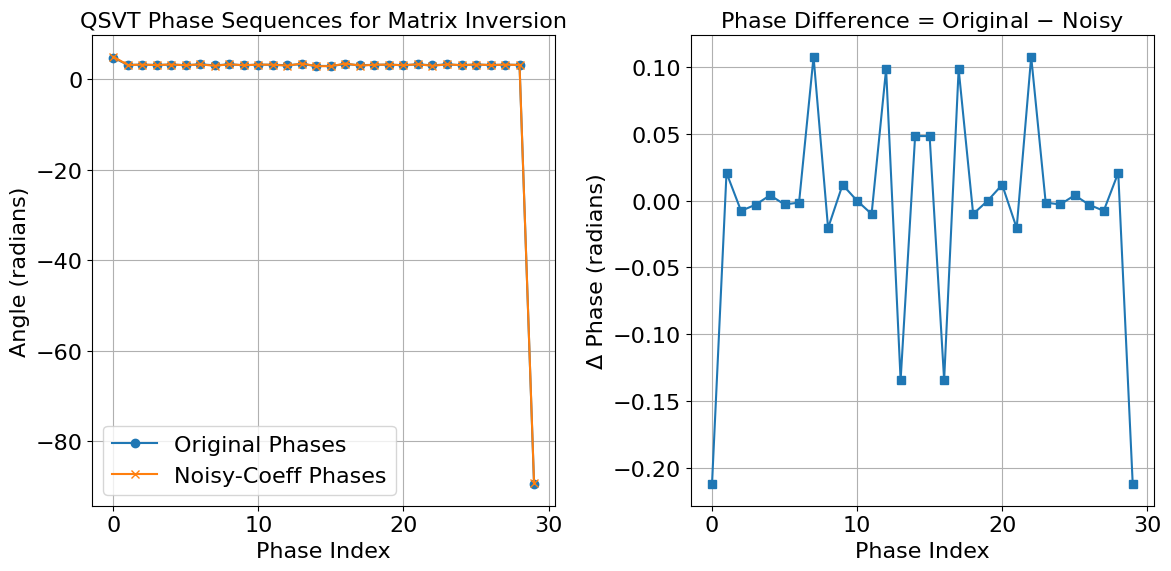

Original coeffs: [ 0.          0.25054832  0.         -0.14629239  0.          0.08051086
  0.          0.00135102  0.         -0.03904751  0.          0.08628945
  0.         -0.09197067  0.          0.10660837  0.         -0.08916949
  0.          0.08359965  0.         -0.057867    0.          0.04664974
  0.         -0.02450966  0.          0.01879831  0.         -0.00429364]
Noisy coeffs:    [ 0.          0.28102003  0.         -0.2502908   0.          0.15555598
  0.          0.00135102  0.         -0.03904751  0.          0.08628945
  0.         -0.09197067  0.          0.20066484  0.         -0.08916949
  0.          0.08359965  0.         -0.057867    0.          0.04664974
  0.         -0.02450966  0.          0.01879831  0.         -0.19939716]
Max |Δphase|: 0.21260141733796445
Original_phase: [  4.71679593   3.12191232   3.16780616   3.09201291   3.20354184
   3.05264564   3.2365866    3.02924991   3.23774518   3.05327726
   3.1795039    3.14401516   3.05475099   3.29473679

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from pyqsp.angle_sequence import QuantumSignalProcessingPhases

def adjust_phases(ang_seq):
    # Convert QSP phases (for R(x)) to QSVT phases (for W(x)) convention
    phases = np.array(ang_seq, dtype=float)
    N = len(phases)
    phases[1:-1] = phases[1:-1] - np.pi / 2
    phases[0] = phases[0] - np.pi / 4
    phases[-1] = phases[-1] + (2 * (N - 1) - 1) * np.pi / 4
    return -2 * phases  # Adjust sign due to exp(-i*phi*Z) convention

# --- original Chebyshev coefficients
coeffs = np.array([
    0.0,  0.25054832,  0.0, -0.14629239,  0.0,  0.08051086,
    0.0,  0.00135102,  0.0, -0.03904751,  0.0,  0.08628945,
    0.0, -0.09197067,  0.0,  0.10660837,  0.0, -0.08916949,
    0.0,  0.08359965,  0.0, -0.05786700,  0.0,  0.04664974,
    0.0, -0.02450966,  0.0,  0.01879831,  0.0, -0.00429364
], dtype=float)

# --- add noise ONLY to selected odd-indexed coefficients
def add_noise_to_coeffs(c, idxs=(1, 3), noise_scale=None, seed=None, kind="gaussian"):
    rng = np.random.default_rng(seed)
    noisy = c.copy()
    if kind == "gaussian":
        deltas = rng.normal(0.0, noise_scale, size=len(idxs))
    elif kind == "uniform":
        half_range = np.sqrt(3) * noise_scale
        deltas = rng.uniform(-half_range, half_range, size=len(idxs))
    else:
        raise ValueError("kind must be 'gaussian' or 'uniform'")
    for i, di in zip(idxs, deltas):
        if 0 <= i < len(noisy):
            noisy[i] += di
    return noisy

# create noisy coefficients
noise_scale = 1e-1
noise_scale_str = format(noise_scale, ".0e")
seed = 42
seed_str = str(seed)
noisy_coeffs = add_noise_to_coeffs(coeffs, idxs=(1, 3, 5, 15, 29), noise_scale=noise_scale, seed=42)

# --- generate phase sequences
ang_seq_orig = QuantumSignalProcessingPhases(coeffs,        signal_operator="Wx", method="laurent", measurement="x")
ang_seq_noisy = QuantumSignalProcessingPhases(noisy_coeffs, signal_operator="Wx", method="laurent", measurement="x")

# --- adjust to QSVT-compatible phase convention
phases_orig = adjust_phases(ang_seq_orig)
phases_noisy = adjust_phases(ang_seq_noisy)

# --- difference
diff = phases_orig - phases_noisy

# --- plotting
plt.figure(figsize=(12, 6))

font_size = 16
plt.rcParams.update({'font.size': font_size})

plt.subplot(1, 2, 1)
plt.plot(phases_orig, label="Original Phases", marker='o')
plt.plot(phases_noisy, label="Noisy-Coeff Phases", marker='x')
plt.title("QSVT Phase Sequences for Matrix Inversion", fontsize=font_size)
plt.xlabel("Phase Index")
plt.ylabel("Angle (radians)")
plt.legend(loc="lower left")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(diff, label="Phase Difference", marker='s')
plt.title("Phase Difference = Original $-$ Noisy", fontsize=font_size)
plt.xlabel("Phase Index")
plt.ylabel("Δ Phase (radians)")
plt.grid(True)

plt.tight_layout()

plt.savefig('figures/func_matrix_inversion_noise_scale_' + noise_scale_str + '.pdf')

plt.show()

# --- quick diagnostics
print("Original coeffs:", coeffs)
print("Noisy coeffs:   ", noisy_coeffs)
print("Max |Δphase|:", np.max(np.abs(diff)))
print("Original_phase:", phases_orig)
print("Noisy_phase:   ", phases_noisy)
